In [2]:
import pennylane as qml
import pennylane.numpy as np

# $\hat{V}_{QA}$

In [3]:
def prepare_Q(U, wires):
    """Prepares Q into the quantum state defined by the unitary U

    Args:
        U (array[complex]): the matrix U to apply to the fiduciary quantum state of Q
        wires (array[int]): the wires representing Q. If Q is a single-qubit, then this should be an array of length 1.
    """
    # Is this the correct way to prepare the Q state?
    qml.QubitUnitary(U, wires)

In [4]:
def prepare_V_QA(alpha, wires):
    """Prepares the V_QA parametric gate given the vector alpha for a Q with k=1 qubits

    Args:
        alpha (array[complex]): The alpha vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, and wires[1..2] shoudl represent A
    """
    # First two gates for each wire
    qml.RY(alpha[0], wires=wires[0])
    qml.RX(alpha[1], wires=wires[0])

    qml.RY(alpha[6], wires=wires[1])
    qml.RX(alpha[7], wires=wires[1])

    qml.RY(alpha[12], wires=wires[2])
    qml.RX(alpha[13], wires=wires[2])

    # Controlled on wire 0
    qml.CRX(alpha[8], wires=[wires[0], wires[1]])
    qml.CRX(alpha[14], wires=[wires[0], wires[2]])

    # Controlled on wire 1
    qml.CRX(alpha[2], wires=[wires[1], wires[0]])
    qml.CRX(alpha[15], wires=[wires[1], wires[2]])

    # Controlled on wire 2
    qml.CRX(alpha[3], wires=[wires[2], wires[0]])
    qml.CRX(alpha[9], wires=[wires[2], wires[1]])

    # Last two gates for each wire
    qml.RY(alpha[4], wires=wires[0])
    qml.RX(alpha[5], wires=wires[0])

    qml.RY(alpha[10], wires=wires[1])
    qml.RX(alpha[11], wires=wires[1])

    qml.RY(alpha[16], wires=wires[2])
    qml.RX(alpha[17], wires=wires[2])

# $\hat{W}_{QAB}$

In [33]:
def prepare_W_QAB(beta, wires):
    """Prepares the W_QAB parametric gate given the vector beta for a Q with k=1 qubits

    Args:
        beta (array[complex]): The beta vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, wires[1..2] should represent A, and wires[3..4] should represent B
    """
    # First two gates for each wire
    qml.RY(beta[0], wires=wires[0])
    qml.RX(beta[1], wires=wires[0])

    qml.RY(beta[10], wires=wires[1])
    qml.RX(beta[11], wires=wires[1])

    qml.RY(beta[20], wires=wires[2])
    qml.RX(beta[21], wires=wires[2])

    qml.RY(beta[30], wires=wires[3])
    qml.RX(beta[31], wires=wires[3])

    qml.RY(beta[34], wires=wires[4])
    qml.RX(beta[35], wires=wires[4])

    # Controlled on wire 3
    qml.CRX(beta[2], wires=[wires[3], wires[0]])
    qml.CRZ(beta[3], wires=[wires[3], wires[0]])

    qml.CRX(beta[12], wires=[wires[3], wires[1]])
    qml.CRZ(beta[13], wires=[wires[3], wires[1]])

    qml.CRX(beta[22], wires=[wires[3], wires[2]])
    qml.CRZ(beta[23], wires=[wires[3], wires[2]])

    # Controlled on wire 4
    qml.CRX(beta[4], wires=[wires[4], wires[0]])
    qml.CRZ(beta[5], wires=[wires[4], wires[0]])

    qml.CRX(beta[14], wires=[wires[4], wires[1]])
    qml.CRZ(beta[15], wires=[wires[4], wires[1]])

    qml.CRX(beta[24], wires=[wires[4], wires[2]])
    qml.CRZ(beta[25], wires=[wires[4], wires[2]])

    # Middle rotation gates for each wire
    qml.RY(beta[6], wires=wires[0])
    qml.RX(beta[7], wires=wires[0])

    qml.RY(beta[16], wires=wires[1])
    qml.RX(beta[17], wires=wires[1])

    qml.RY(beta[26], wires=wires[2])
    qml.RX(beta[27], wires=wires[2])

    qml.RY(beta[22], wires=wires[3])
    qml.RX(beta[23], wires=wires[3])

    qml.RY(beta[36], wires=wires[4])
    qml.RX(beta[37], wires=wires[4])

    # Controlled to apply on wire 0
    qml.ctrl(qml.RZ(beta[8], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])
    qml.ctrl(qml.RX(beta[9], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])

    # Controlled to apply on wire 1
    qml.ctrl(qml.RZ(beta[18], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])
    qml.ctrl(qml.RX(beta[19], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])

    # Controlled to apply on wire 2
    qml.ctrl(qml.RZ(beta[28], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])
    qml.ctrl(qml.RX(beta[29], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])

### Logic diagram of $\hat{V}_{QA}$ and $\hat{W}_{QAB}$

In [34]:
alpha_length = 18
beta_length = 38
test_alpha = np.random.uniform(0, np.pi, size=(alpha_length,))
test_beta = np.random.uniform(0, np.pi, size=(beta_length,))

In [35]:
Q_wires= [0]
A_wires = [1,2]
B_wires = [3,4]
dev = qml.device('default.qubit', wires=len(Q_wires) + len(A_wires) + len(B_wires))

@qml.qnode(dev)
def test_V_QA(alpha):
    prepare_V_QA(alpha, Q_wires + A_wires)
    return qml.state()

@qml.qnode(dev)
def test_W_QAB(beta):
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    return qml.state()

c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[k

(<Figure size 1300x400 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x148053ee610>)

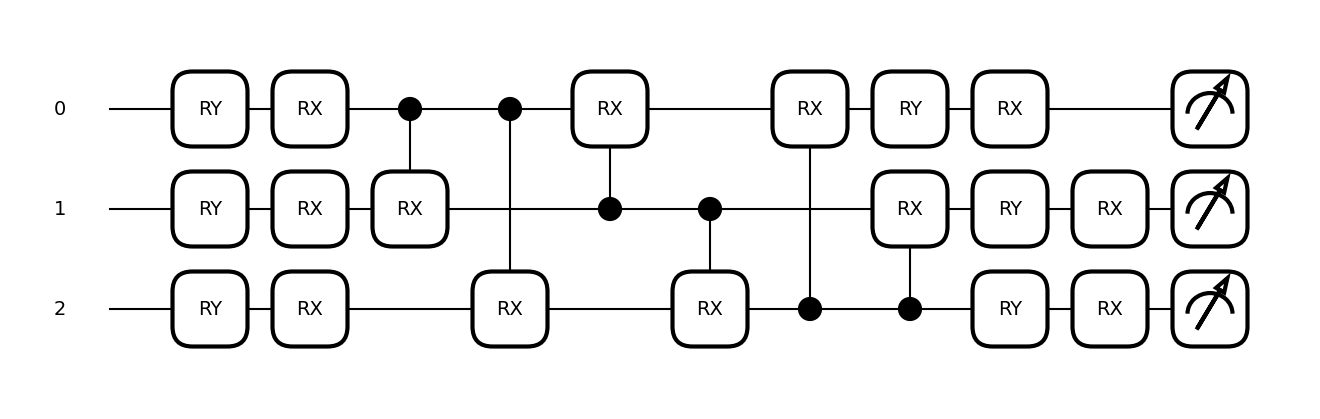

In [53]:
qml.draw_mpl(test_V_QA)(test_alpha)

c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[k

(<Figure size 2500x600 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x148028215e0>)

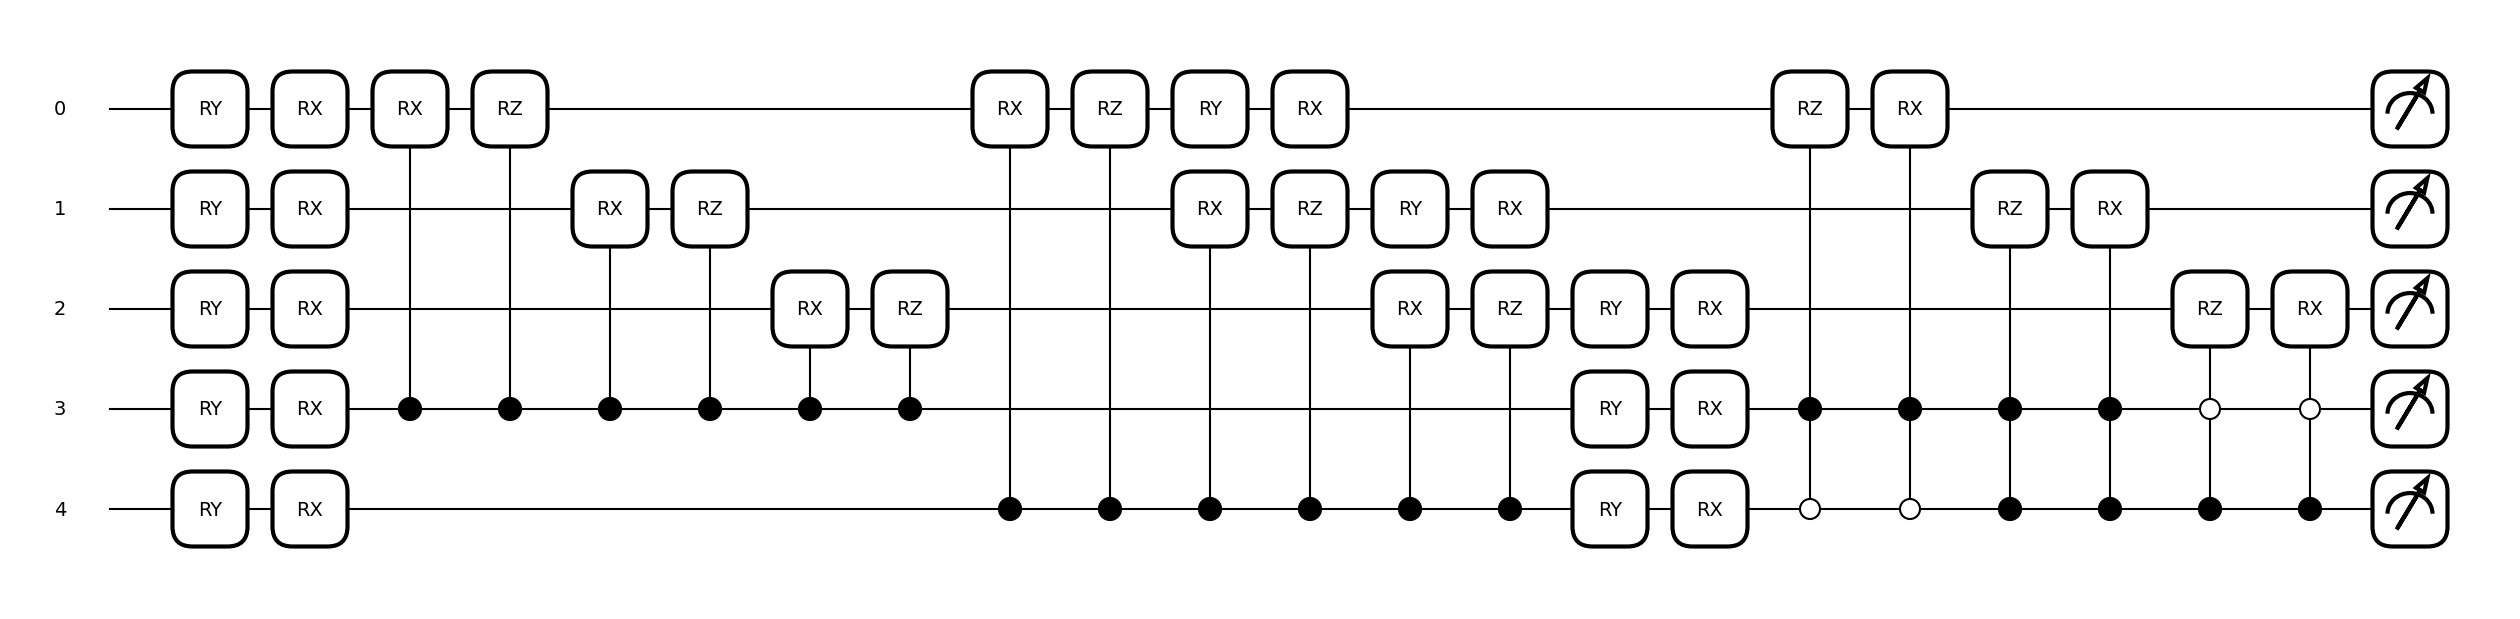

In [38]:
qml.draw_mpl(test_W_QAB)(test_beta)

# Implementation of the VQA

In [69]:
Q_qubits = 1
A_qubits = 2
B_qubits = 2

Q_wires = list(range(Q_qubits))
A_wires = list(range(Q_qubits, Q_qubits + A_qubits))
B_Wires = list(range(Q_qubits + A_qubits, Q_qubits + A_qubits + B_qubits))

dev = qml.device('default.qubit', wires=Q_qubits + A_qubits + B_qubits, shots=1)

@qml.qnode(dev)
def VQA(U, alpha, beta):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)
    # Insert noise
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    return qml.sample()

In [73]:
U = qml.T.compute_matrix()

In [75]:
VQA(U, test_alpha, test_beta)

tensor([0, 0, 0, 0, 1], dtype=int64, requires_grad=True)

c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
c:\Users\JUSTIN\AppData\Local\Programs\Python\Python38\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[k

(<Figure size 4700x600 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x14802fa61f0>)

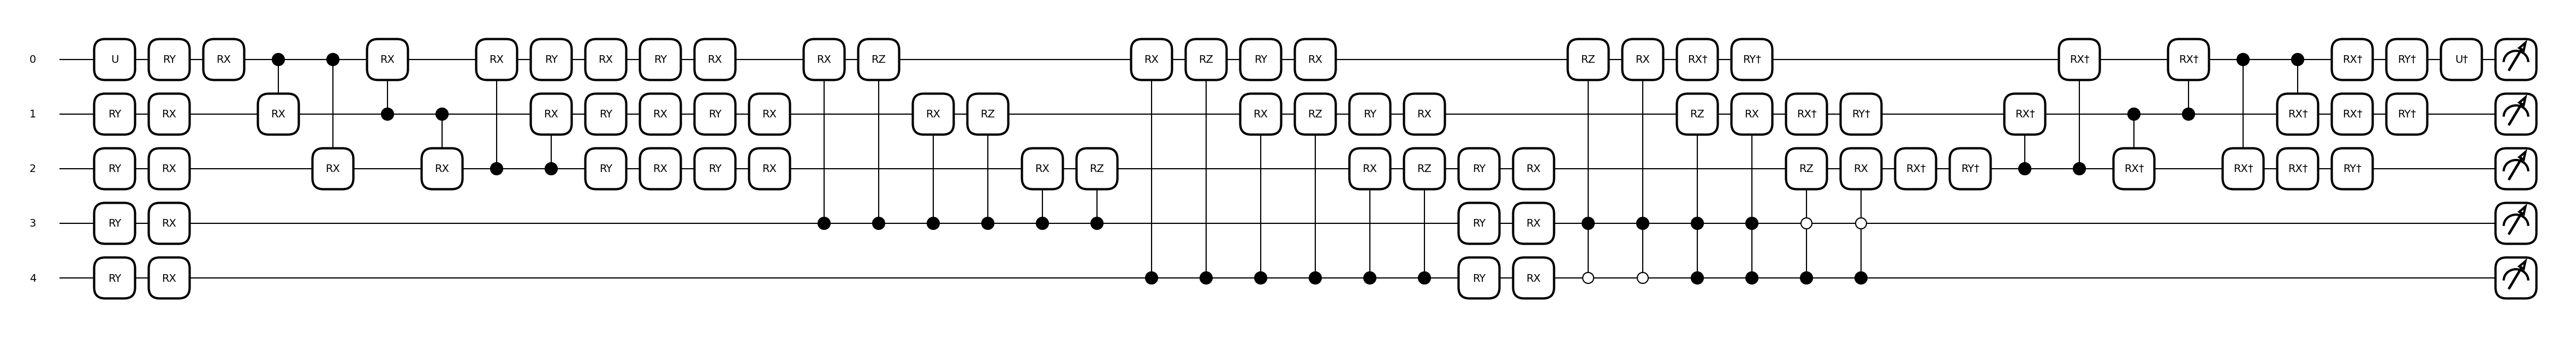

In [76]:
qml.draw_mpl(VQA)(U, test_alpha, test_beta)